In [15]:
import sys, os
module_path = os.path.abspath(os.path.join('..', 'src'))

if module_path not in sys.path:
    print(f"Adding {module_path} to sys.path")
    sys.path.append(module_path)


In [22]:
import pandas as pd

from constants import PROJECT_ROOT
dataset_path = f"{PROJECT_ROOT}/outputs/twitter_posts_classified_2025-09-06-H:19-M:31.csv"
df = pd.read_csv(dataset_path)
df = df.rename(columns={"biased": "is_antisemitic"})
df["prediction"] = df["prediction"].fillna("None")
df.head()

,original_index,text,is_antisemitic,keyword,prediction,description,model,max_tokens,temperature,usage
0,5310,RT : A core part of my Jewish education growi...,0,Jews,None,This text expresses a Jewish person's perspect...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4774, 'completion_tokens': 7..."
1,838,President DELIVERS yet another breakthrough f...,0,Israel,None,This text celebrates a diplomatic achievement ...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4772, 'completion_tokens': 6..."
2,3518,Totally creepy. Deep down think they hate Jews...,0,Jews,None,The text expresses suspicion about a group's m...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4756, 'completion_tokens': 7..."
3,1333,U.S. Virgin Islands (????)\n+\nIsrael (????)\...,0,Israel,None,This appears to be a simple wordplay or pun co...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4762, 'completion_tokens': 9..."
4,5843,Very distressing but not surprising considerin...,0,Jews,None,The text expresses concern about antisemitism ...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4764, 'completion_tokens': 6..."


In [27]:
import json
import pandas as pd
import ast


# Try different parsing methods
def safe_parse_usage(usage_str):
    try:
        # Try JSON first
        return json.loads(usage_str)
    except:
        try:
            # Try ast.literal_eval for Python dict strings
            return ast.literal_eval(usage_str)
        except:
            try:
                # Try eval as last resort (if it's a Python dict)
                return eval(usage_str)
            except:
                return None

# Parse the usage column
df['usage_parsed'] = df['usage'].apply(safe_parse_usage)

# Check how many failed to parse
failed_count = df['usage_parsed'].isnull().sum()
print(f"Failed to parse: {failed_count} rows out of {len(df)}")

# Extract token counts (handle None values)
df['prompt_tokens'] = df['usage_parsed'].apply(lambda x: x['prompt_tokens'] if x else 0)
df['completion_tokens'] = df['usage_parsed'].apply(lambda x: x['completion_tokens'] if x else 0)
df['total_tokens'] = df['usage_parsed'].apply(lambda x: x['total_tokens'] if x else 0)

# Calculate totals
total_prompt_tokens = df['prompt_tokens'].sum()
total_completion_tokens = df['completion_tokens'].sum()
total_tokens = df['total_tokens'].sum()

# Claude Sonnet 4 pricing: $3/M input, $15/M output
input_cost = (total_prompt_tokens / 1_000_000) * 3
output_cost = (total_completion_tokens / 1_000_000) * 15
total_cost = input_cost + output_cost

print(f"Total Prompt Tokens: {total_prompt_tokens:,}")
print(f"Total Completion Tokens: {total_completion_tokens:,}")
print(f"Total Tokens: {total_tokens:,}")
print(f"\nCost Breakdown:")
print(f"Input Cost: ${input_cost:.4f}")
print(f"Output Cost: ${output_cost:.4f}")
print(f"Total Cost: ${total_cost:.4f}")

# Also show per-row statistics
print(f"\nPer-row averages:")
print(f"Avg prompt tokens: {total_prompt_tokens/len(df):.1f}")
print(f"Avg completion tokens: {total_completion_tokens/len(df):.1f}")
print(f"Avg cost per row: ${total_cost/len(df):.4f}")

Failed to parse: 1 rows out of 750
Total Prompt Tokens: 3,572,984
Total Completion Tokens: 63,256
Total Tokens: 3,636,240

Cost Breakdown:
Input Cost: $10.7190
Output Cost: $0.9488
Total Cost: $11.6678

Per-row averages:
Avg prompt tokens: 4764.0
Avg completion tokens: 84.3
Avg cost per row: $0.0156


In [28]:
df["prediction"].value_counts()

prediction
IHRA Definition                            381
None                                       316
Jerusalem Declaration + IHRA Definition     52
LLM_ERROR                                    1
Name: count, dtype: int64

In [29]:
df["predicted_antisemitic"] = (df['prediction'].isin(['IHRA Definition', 'Jerusalem Declaration + IHRA Definition'])).astype(int)
df

,original_index,text,is_antisemitic,keyword,prediction,description,model,max_tokens,temperature,usage,usage_parsed,prompt_tokens,completion_tokens,total_tokens,predicted_antisemitic
0,5310,RT : A core part of my Jewish education growi...,0,Jews,None,This text expresses a Jewish person's perspect...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4774, 'completion_tokens': 7...","{'prompt_tokens': 4774, 'completion_tokens': 7...",4774,74,4848,0
1,838,President DELIVERS yet another breakthrough f...,0,Israel,None,This text celebrates a diplomatic achievement ...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4772, 'completion_tokens': 6...","{'prompt_tokens': 4772, 'completion_tokens': 6...",4772,60,4832,0
2,3518,Totally creepy. Deep down think they hate Jews...,0,Jews,None,The text expresses suspicion about a group's m...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4756, 'completion_tokens': 7...","{'prompt_tokens': 4756, 'completion_tokens': 7...",4756,79,4835,0
3,1333,U.S. Virgin Islands (????)\n+\nIsrael (????)\...,0,Israel,None,This appears to be a simple wordplay or pun co...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4762, 'completion_tokens': 9...","{'prompt_tokens': 4762, 'completion_tokens': 9...",4762,95,4857,0
4,5843,Very distressing but not surprising considerin...,0,Jews,None,The text expresses concern about antisemitism ...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4764, 'completion_tokens': 6...","{'prompt_tokens': 4764, 'completion_tokens': 6...",4764,63,4827,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,4463,How the Labour Party's witch-hunters target Je...,1,Jews,None,This text criticizes the Labour Party's handli...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4779, 'completion_tokens': 8...","{'prompt_tokens': 4779, 'completion_tokens': 8...",4779,87,4866,0
746,4299,If #PapaShane had said it was the Jews ruining...,1,Jews,IHRA Definition,The text contains a hypothetical antisemitic s...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4783, 'completion_tokens': 1...","{'prompt_tokens': 4783, 'completion_tokens': 1...",4783,100,4883,1
747,280,Israel is currently a failing state. Racist an...,1,Israel,None,The text criticizes Israel's current state and...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4735, 'completion_tokens': 8...","{'prompt_tokens': 4735, 'completion_tokens': 8...",4735,86,4821,0
748,5295,RT : “I can’t be a Zionist. No way. It is such...,1,Jews,None,The text expresses opposition to Zionism while...,anthropic/claude-sonnet-4,800,0.1,"{'prompt_tokens': 4765, 'completion_tokens': 6...","{'prompt_tokens': 4765, 'completion_tokens': 6...",4765,66,4831,0


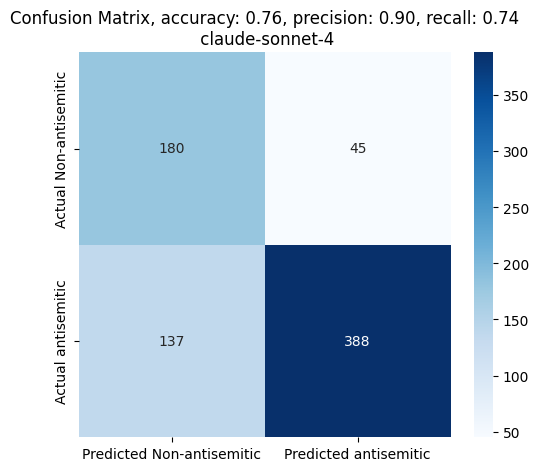

In [30]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(df['is_antisemitic'], df["predicted_antisemitic"])
precision = precision_score(df['is_antisemitic'], df["predicted_antisemitic"])
recall = recall_score(df['is_antisemitic'], df["predicted_antisemitic"])
accuracy = accuracy_score(df['is_antisemitic'], df["predicted_antisemitic"])

selected_model = df["model"].unique()[0]
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Non-antisemitic', 'Predicted antisemitic'],
            yticklabels=['Actual Non-antisemitic', 'Actual antisemitic'])
plt.title(f'Confusion Matrix, accuracy: {accuracy:.2f}, precision: {precision:.2f}, recall: {recall:.2f}\n {selected_model.split("/")[-1]}')
plt.show()

In [31]:
#lets see our false negatives
columns = ['text', 'is_antisemitic', 'predicted_antisemitic', 'prediction', 'description']
false_positives = df[(df['predicted_antisemitic'] == 1) & (df['is_antisemitic'] == 0)][columns]
false_negatives = df[(df['predicted_antisemitic'] == 0) & (df['is_antisemitic'] == 1)][columns]
true_positives = df[(df['predicted_antisemitic'] == 1) & (df['is_antisemitic'] == 1)][columns]
true_negatives = df[(df['predicted_antisemitic'] == 0) & (df['is_antisemitic'] == 0)][columns]

In [32]:
from itables import show
import itables.options as opt

# Configure for better display
opt.lengthMenu = [10, 25, 50, 100]
opt.maxBytes = 0  # No limit on table size




In [33]:
show(false_positives, caption="False Positives")

Loading ITables v2.5.2 from the internet... (need help?)


In [34]:
show(false_negatives, caption="False Negatives")


Loading ITables v2.5.2 from the internet... (need help?)


In [35]:
show(true_positives, caption="True Positives")


Loading ITables v2.5.2 from the internet... (need help?)


In [36]:
show(true_negatives, caption="True Negatives")

Loading ITables v2.5.2 from the internet... (need help?)
